In [1]:
import os 
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
%matplotlib inline

In [3]:
# Some of the columns we will look at can be quite wide, but it's good to get an idea of what they contain
print(pd.get_option('max_colwidth'))
pd.set_option('max_colwidth',500)

50


## File/dir locations


In [4]:
DATA_DIR = os.getenv("DATA_DIR")
filename = "preprocessed_taxon_pageseq_20190114_20190116.csv.gz"
# df_file = os.path.join(DATA_DIR, "processed_journey", filename)
# df_reduced_file = os.path.join(DATA_DIR, "processed_journey", "reduced_"+filename)
# df_rel_file = os.path.join(DATA_DIR, "processed_journey", "rel_"+filename)
df_doo_file = os.path.join(
    DATA_DIR, "processed_journey",
    "doo_prelim_meta_standard_with_pageseq_from_29-10_to_04-11-2018.csv.gz")

Load up a data file that isn't too large - we just want to check that the putative metrics for analysis can be derived from the data. This data was produced by an early version of the pipeline and is missing some descriptive variables, such as taxons etc. However, it contains the sequences of pages and behaviours (or events) of users on those pages, including interaction with the sidebar and the related links contained therein.

In [5]:
df = pd.read_csv(df_doo_file, compression="gzip")

In [6]:
df.head(2)

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,num_event_cats,Event_cats_agg,Event_cat_act_agg,Page_List_NL,Page_Seq_NL,Occurrences_NL
0,/guidance/rates-and-thresholds-for-employers-2016-to-2017<<PAGE<:<NULL<:<NULL,/guidance/rates-and-thresholds-for-employers-2016-to-2017,87,306.0,"[('desktop', 64), ('mobile', 11), ('tablet', 12)]","[('20181031', 33), ('20181029', 27), ('20181102', 17), ('20181104', 10)]","[('/guidance/rates-and-thresholds-for-employers-2016-to-2017', 'PAGE<:<NULL<:<NULL')]",['/guidance/rates-and-thresholds-for-employers-2016-to-2017'],/guidance/rates-and-thresholds-for-employers-2016-to-2017,"[('PAGE_NULL', 'PAGE_NULL')]",1,"[('PAGE_NULL', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 1)]",['/guidance/rates-and-thresholds-for-employers-2016-to-2017'],/guidance/rates-and-thresholds-for-employers-2016-to-2017,6198.0
1,/sure-start-maternity-grant/how-to-claim<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<Download Link Clicked<:<https://assets.pu...,/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,104,385.0,"[('mobile', 50), ('desktop', 50), ('tablet', 4)]","[('20181031', 34), ('20181029', 31), ('20181102', 24), ('20181104', 15)]","[('/sure-start-maternity-grant/how-to-claim', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<Download Link Clic...","['/sure-start-maternity-grant/how-to-claim', '/government/publications/sure-start-maternity-grant-claim-form']",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf')]",3,"[('PAGE_NULL', 2), ('External Link Clicked', 1), ('Download Link Clicked', 1)]","[(('PAGE_NULL', 'PAGE_NULL'), 2), (('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1), (('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), 1)]","['/sure-start-maternity-grant/how-to-claim', '/government/publications/sure-start-maternity-grant-claim-form']",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,7010.0


In [7]:
df.shape

(2035522, 16)

## Remove tablet occurrences

Tablet data won't be in our future datasets so let's remove it here. We won't be using it in future because depending on screen width/orientation it can display the page in a "mobile" or "desktop" format, where related links are in different places, this will make analysis of the data more complicated.

In [8]:
def device_count(x, device):
    return sum([value for item, value in x if item == device])

df["TabletCount"] = df['DeviceCategories'].apply(
    ast.literal_eval).map(lambda x: device_count(x, "tablet"))
df["Occurrences"] = df["Occurrences"] - df["TabletCount"]
df = df[df["Occurrences"] != 0]
df.shape

(1893413, 17)

## Planning

Inspecting our putative metrics for detecting a change in user navigation experience gives us three ratios. Thus we need to check that we can get the numerator and denominator from the data for each of these metrics.


In [11]:
df['Event_cat_act_agg']= df['Event_cat_act_agg'].apply(ast.literal_eval)

In [12]:
events = []
for items in df['Event_cat_act_agg']:
    for event in items:
        events.append(event[0])

In [13]:
events[:4]

[('PAGE_NULL', 'PAGE_NULL'),
 ('PAGE_NULL', 'PAGE_NULL'),
 ('External Link Clicked',
  'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'),
 ('Download Link Clicked',
  'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf')]

In [51]:
# look at counter of events
# Counter(events)

Related link events eventCategory:
- relatedLinkClicked (eventAction e.g. 1.3 Related content)

There is more than one level to this Event, we are specifically interested in "Related content" (as this is the sidebar of the page, the related links we are interested in).

### Navigation events
Potential nav events eventCategory:
- breadcrumbClicked
- homeLinkClicked -  First full day of data 08 Nov 2018
- searchResults - deprecated according to [GOV.UK wiki](https://gov-uk.atlassian.net/wiki/spaces/GOVUK/pages/23855552/Analytics+on+GOV.UK#AnalyticsonGOV.UK-Events), but still firing on the site - **doesn't fire if there are no search results, so let's use page = search instead**  i.e. '/search?q=' in page
- relatedLinkClicked (eventAction e.g. 1.1 Explore the topic) - Explore the topic links at the bottom of a content page

**What events correspond to the links in grey right at the bottom of the page?**

more events to look into:
- ~~firstLevelBrowseLinkClicked~~  relates to browse page
- ~~secondLevelBrowseLinkClicked~~ relates to browse page

- ~~navDocumentCollectionLinkClicked~~ click on a link that leads you to a collection of documents, e.g from https://www.gov.uk/government/collections/data-protection-act-2018 
- ~~navFinderLinkClicked~~ click a link from a finder's results, eg. from https://www.gov.uk/raib-reports
- ~~navAccordionLinkClicked~~ expand a section on a page e.g. https://www.gov.uk/world/germany#/world/emergency-help-for-british-nationals-germany
- ~~navLeafLinkClicked~~ click on a section from a taxon page like https://www.gov.uk/world/brexit-ireland
- ~~navServicesInformationLinkClicked~~ click a link from a services_and_information page like https://www.gov.uk/government/organisations/hm-revenue-customs/services-information
- ~~navSubtopicContentItemLinkClicked~~	- click on a content item from a topic page, e.g. 'Self-employed National Insurance rates' from https://www.gov.uk/topic/personal-tax/national-insurance
- ~~navSubtopicLinkClicked~~ a link to a subtopic from a topic page is clicked, e.g from https://www.gov.uk/topic/working-sea
- navTopicLinkClicked not in this sample
- ~~searchBoxFilter~~ use the search box on a page like https://www.gov.uk/world
- ~~navGridContentClicked~~ exploring a subtopic from a topic page, e.g. the grid at the bottom of https://www.gov.uk/environment/climate-change-energy


**step by step - do not include?**
- ~~stepNavHeaderClicked~~ - if a content page is part of a step by step, this is clicking the link to the step by step at the top of the page - does this indicate they are lost or they are where they want to be?
- ~~stepNavLinkClicked~~ - a link to click through to another part of the step by step is clicked
- ~~stepNavPartOfClicked~~ - sidebar part of step by step link clicked

In [17]:
# look at search pages
def contains_search(x):
    return '/search?q=' in x 

In [306]:
# df[df['Sequence'].map(contains_search)]

In [19]:
# use this fn to look at rows in the DF that contain a specific event category, or 
# anything else you want to find in 'Sequence', then you can look at the pages to 
# work out how the event can occur
def look_at_event(event_cat):
    return df[df['Sequence'].map(lambda x: event_cat in x)].head(5)

In [307]:
# df[df['Sequence'].map(lambda x: '>>/<<' in x)]

### Page types

We want to know what page types different pages are because we care about navigation elements clicked **from a content page** and the total number of journeys that contain **only content pages and related links**.

Initially we wanted to use [User journey supertype](https://docs.publishing.service.gov.uk/document-types/user_journey_document_supertype.html) from [custom dimensions](https://gov-uk.atlassian.net/wiki/spaces/GOVUK/pages/23855552/Analytics+on+GOV.UK#AnalyticsonGOV.UK-customDimensionsCustomdimensions), where each page is either classified as 'finding' or 'thing'. Unfortunately this dimension is poorly populated in BigQuery due to someone disabling it, and occasionally the same page path and page title can be reported as both a 'finding' and a 'thing' at different times (e.g. the GOV.UK homepage).

The next option is using 'Format' (document type) from [custom dimensions](https://gov-uk.atlassian.net/wiki/spaces/GOVUK/pages/23855552/Analytics+on+GOV.UK#AnalyticsonGOV.UK-customDimensionsCustomdimensions), which is a lot better populated but a lot more granular, you can find a sample of a day's data with pageviews from GA [here](https://docs.google.com/spreadsheets/d/1-jen8DbRgvmvF9aYapmwsFAe0ncHeq5y-ks75iyCvVU/edit#gid=177174931).

*NB - a data dump from the content API is probably the most reliable source for a mapping of page paths to document types and then to finding/thing, however there's a bit of outlay in understanding how that data can be accessed and how it is structured so a BigQuery query is most appropriate for a first stab at this.*

**TODO** one query to get pagePath, format (or map this to finding/thing), content ID, where content_id != '00000000-0000-0000-0000-000000000000'

In [52]:
ProjectID = 'govuk-bigquery-analytics'
KEY_DIR = os.getenv("BQ_KEY_DIR")
key_file_path = os.path.join(KEY_DIR, os.listdir(KEY_DIR)[0])

In [132]:
# OLD_QUERY = """
#     SELECT DISTINCT
#     content_id,
#     pagePath,
#     IF(document_type IN ('document_collection',
#       'finder',
#       'homepage',
#       'license_finder',
#       'mainstream_browse_page',
#       'organisation',
#       'search',
#       'service_manual_homepage',
#       'service_manual_topic',
#       'services_and_information',
#       'taxon',
#       'topic',
#       'topical_event'),'finding','thing') as finding_or_thing
#     FROM
#       (SELECT 
#           (
#         SELECT
#           value
#         FROM
#           hits.customDimensions
#         WHERE
#           index=4) AS content_id,
#           hits.page.pagePath, 
#         (
#         SELECT
#           value
#         FROM
#           hits.customDimensions
#         WHERE
#           index=2) AS document_type
#       FROM
#         `govuk-bigquery-analytics.87773428.ga_sessions_*` AS sessions
#       CROSS JOIN
#         UNNEST(sessions.hits) AS hits
#          WHERE _TABLE_SUFFIX BETWEEN '20190121'
#      AND '20190127'
#       )
#     WHERE
#       content_id != '00000000-0000-0000-0000-000000000000'
#       AND content_id != '[object Object]'
#       AND content_id IS NOT NULL
# """

In [156]:
QUERY = """
    SELECT 
    pagePath,
    MAX(IF(document_type IN ('document_collection',
      'finder',
      'homepage',
      'license_finder',
      'mainstream_browse_page',
      'organisation',
      'search',
      'service_manual_homepage',
      'service_manual_topic',
      'services_and_information',
      'taxon',
      'topic',
      'topical_event'),1,0)) AS is_finding
    FROM
      (SELECT 
          (
        SELECT
          value
        FROM
          hits.customDimensions
        WHERE
          index=4) AS content_id,
          hits.page.pagePath, 
        (
        SELECT
          value
        FROM
          hits.customDimensions
        WHERE
          index=2) AS document_type
      FROM
        `govuk-bigquery-analytics.87773428.ga_sessions_*` AS sessions
      CROSS JOIN
        UNNEST(sessions.hits) AS hits
         WHERE _TABLE_SUFFIX BETWEEN '20190121'
     AND '20190127'
      )
    WHERE
      content_id != '00000000-0000-0000-0000-000000000000'
      AND content_id != '[object Object]'
      AND content_id IS NOT NULL
    GROUP BY 1
"""

In [157]:
df_finding_thing = pd.io.gbq.read_gbq(QUERY,
                           project_id=ProjectID,
                           reauth=False,
                           # verbose=True,
                           private_key=key_file_path,
                           dialect='standard')

In [158]:
df_finding_thing.to_csv('../../data/raw_bq_extract/document_types.csv.gz',
             sep="\t", index=False, compression='gzip')

In [159]:
df_finding_thing.shape

(2040813, 2)

In [161]:
df_finding_thing[df_finding_thing['is_finding']==0].shape

(1071454, 2)

In [162]:
df_finding_thing_read = pd.read_csv(
    '../../data/raw_bq_extract/document_types.csv.gz',
             sep="\t", compression='gzip')

In [163]:
df_finding_thing_read.head()

,pagePath,is_finding
0,/jobsearch,0
1,/pay-leave-for-parents/y,0
2,/student-finance-calculator/y/2018-2019/uk-full-time,0
3,/government/publications/application-for-confirmation-of-british-nationality-status-form-ns,0
4,/pip/eligibility,0


## journey_click_rate
There is no difference in the proportion of journeys using at least one related link (journey_click_rate) between page variant A and page variant B.



\begin{equation*}
\frac{\text{total number of journeys including at least one click on a related link}}{\text{total number of journeys}}
\end{equation*}

### total number of journeys including at least one click on a related link
The numerator.

We need to check within the Sequence column, whether the corresponding user journey has an Event where a related link was clicked. There is more than one level to this Event, we are specifically interested in "Related content" (as this is the sidebar of the page, the related links we are interested in).

In [21]:
#Compute whether a journey includes at least one related link click
def is_related(x):
    return all(cond in x for cond in ["relatedLinkClicked","Related content"])

Please note, `is_related` does not make sure that `relatedLinkClicked` and `Related content` exist in the same event in `Sequence`, example below

In [22]:
is_related(
    '/garden-bonfires-rules<<PAGE<:<relatedLinkClicked<:<NULL>>/garden-bonfires-rules<<EVENT<:<NULL<:<1.4 Related content'
    )

True

In [23]:
# map across the Sequence variable, which includes pages and Events
# we want to pass all the list elements to a function one-by-one and then collect the output.
df["Has_Related"] = df["Sequence"].map(is_related)

In [24]:
# this gives a logical column
df["Has_Related"].head()

0    False
1    False
2    False
3    False
4    False
Name: Has_Related, dtype: bool

In [25]:
# We can filter for True and sum
df[df["Has_Related"]].Occurrences.sum()

131678

In [26]:
# sense check by inspecting filtered df
df[df["Has_Related"]].head(3)

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,num_event_cats,Event_cats_agg,Event_cat_act_agg,Page_List_NL,Page_Seq_NL,Occurrences_NL,TabletCount,Has_Related
2608,/garden-bonfires-rules<<PAGE<:<NULL<:<NULL>>/garden-bonfires-rules<<EVENT<:<relatedLinkClicked<:<1.4 Related content,/garden-bonfires-rules,1,7483.0,"[('mobile', 1)]","[('20181031', 1)]","[('/garden-bonfires-rules', 'PAGE<:<NULL<:<NULL'), ('/garden-bonfires-rules', 'EVENT<:<relatedLinkClicked<:<1.4 Related content')]",['/garden-bonfires-rules'],/garden-bonfires-rules,"[('PAGE_NULL', 'PAGE_NULL'), ('relatedLinkClicked', '1.4 Related content')]",2,"[('PAGE_NULL', 1), ('relatedLinkClicked', 1)]","[((PAGE_NULL, PAGE_NULL), 1), ((relatedLinkClicked, 1.4 Related content), 1)]",['/garden-bonfires-rules'],/garden-bonfires-rules,114000.0,0,True
3401,/check-state-pension<<PAGE<:<NULL<:<NULL>>/check-state-pension<<EVENT<:<relatedLinkClicked<:<1.1 Related content,/check-state-pension,1,17093.0,"[('mobile', 1)]","[('20181031', 1)]","[('/check-state-pension', 'PAGE<:<NULL<:<NULL'), ('/check-state-pension', 'EVENT<:<relatedLinkClicked<:<1.1 Related content')]",['/check-state-pension'],/check-state-pension,"[('PAGE_NULL', 'PAGE_NULL'), ('relatedLinkClicked', '1.1 Related content')]",2,"[('PAGE_NULL', 1), ('relatedLinkClicked', 1)]","[((PAGE_NULL, PAGE_NULL), 1), ((relatedLinkClicked, 1.1 Related content), 1)]",['/check-state-pension'],/check-state-pension,413249.0,0,True
4353,/child-benefit-rates<<EVENT<:<relatedLinkClicked<:<1.6 Related content>>/child-tax-credit<<PAGE<:<NULL<:<NULL,/child-tax-credit,2,4239.0,"[('mobile', 1), ('desktop', 1)]","[('20181031', 1), ('20181029', 1)]","[('/child-benefit-rates', 'EVENT<:<relatedLinkClicked<:<1.6 Related content'), ('/child-tax-credit', 'PAGE<:<NULL<:<NULL')]",['/child-tax-credit'],/child-tax-credit,"[('relatedLinkClicked', '1.6 Related content'), ('PAGE_NULL', 'PAGE_NULL')]",2,"[('relatedLinkClicked', 1), ('PAGE_NULL', 1)]","[((relatedLinkClicked, 1.6 Related content), 1), ((PAGE_NULL, PAGE_NULL), 1)]",['/child-tax-credit'],/child-tax-credit,51353.0,0,True


### total number of journeys
The denominator.

In [27]:
df.Occurrences.sum()

10569850

### final metric

Given this sample, we see:

In [28]:
df[df["Has_Related"]].Occurrences.sum() / df.Occurrences.sum()

0.012457887292629508

The above metric considers at least one related link clicked, but on some journeys more than one related link might get clicked. We can use the following columns to help us.

In [29]:
df['Event_cats_agg'].head(3)

0                                                                [('PAGE_NULL', 1)]
1    [('PAGE_NULL', 2), ('External Link Clicked', 1), ('Download Link Clicked', 1)]
2                                                                [('PAGE_NULL', 1)]
Name: Event_cats_agg, dtype: object

In [30]:
df['Event_cat_act_agg'].head(3)

0                                                                                                                                                                                                                                                                                                                                                          [((PAGE_NULL, PAGE_NULL), 1)]
1    [((PAGE_NULL, PAGE_NULL), 2), ((External Link Clicked, https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf), 1), ((Download Link Clicked, https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf), 1)]
2                                                                                                                                                                                                                                                     

## ratio of clicks on navigation elements vs. clicks on related links

There is no statistically significant difference in the ratio of clicks on navigation elements vs. clicks on related links between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of navigation element click events from content pages}}{\text{total number of related link click events}}
\end{equation*}

### total number of related link click events

we need to check `Related content` is in the event, because the `relatedLinkClicked` is also used for "explore the topic" links at the bottom of the page, with the event action containing `Explore the topic`, e.g. `(('relatedLinkClicked', '2.1 Explore the topic'), 1)`

In [31]:
# example of Event_cat_act_agg
df['Event_cat_act_agg'][2608]

[(('PAGE_NULL', 'PAGE_NULL'), 1),
 (('relatedLinkClicked', '1.4 Related content'), 1)]

In [32]:
# If the event category is 'relatedLinkClicked' and the event action contains 'Related content', 
# return the count of that event
def get_number_of_events_rl(event):
    if event[0][0] == 'relatedLinkClicked' and 'Related content' in event[0][1]:
        return event[1]
    return 0

In [33]:
def sum_related_click_events(event_list):
    return sum([get_number_of_events_rl(event) for event in event_list])

In [35]:
# get the number of related links clicks per Sequence
df['Related Links Clicks per seq'] = df['Event_cat_act_agg'].map(sum_related_click_events)

# get the total number of related links clicks for that row (clicks per sequence multiplied by occurrences)
df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']

In [36]:
df[df["Has_Related"]].head(3)

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,num_event_cats,Event_cats_agg,Event_cat_act_agg,Page_List_NL,Page_Seq_NL,Occurrences_NL,TabletCount,Has_Related,Related Links Clicks per seq,Related Links Clicks row total
2608,/garden-bonfires-rules<<PAGE<:<NULL<:<NULL>>/garden-bonfires-rules<<EVENT<:<relatedLinkClicked<:<1.4 Related content,/garden-bonfires-rules,1,7483.0,"[('mobile', 1)]","[('20181031', 1)]","[('/garden-bonfires-rules', 'PAGE<:<NULL<:<NULL'), ('/garden-bonfires-rules', 'EVENT<:<relatedLinkClicked<:<1.4 Related content')]",['/garden-bonfires-rules'],/garden-bonfires-rules,"[('PAGE_NULL', 'PAGE_NULL'), ('relatedLinkClicked', '1.4 Related content')]",2,"[('PAGE_NULL', 1), ('relatedLinkClicked', 1)]","[((PAGE_NULL, PAGE_NULL), 1), ((relatedLinkClicked, 1.4 Related content), 1)]",['/garden-bonfires-rules'],/garden-bonfires-rules,114000.0,0,True,1,1
3401,/check-state-pension<<PAGE<:<NULL<:<NULL>>/check-state-pension<<EVENT<:<relatedLinkClicked<:<1.1 Related content,/check-state-pension,1,17093.0,"[('mobile', 1)]","[('20181031', 1)]","[('/check-state-pension', 'PAGE<:<NULL<:<NULL'), ('/check-state-pension', 'EVENT<:<relatedLinkClicked<:<1.1 Related content')]",['/check-state-pension'],/check-state-pension,"[('PAGE_NULL', 'PAGE_NULL'), ('relatedLinkClicked', '1.1 Related content')]",2,"[('PAGE_NULL', 1), ('relatedLinkClicked', 1)]","[((PAGE_NULL, PAGE_NULL), 1), ((relatedLinkClicked, 1.1 Related content), 1)]",['/check-state-pension'],/check-state-pension,413249.0,0,True,1,1
4353,/child-benefit-rates<<EVENT<:<relatedLinkClicked<:<1.6 Related content>>/child-tax-credit<<PAGE<:<NULL<:<NULL,/child-tax-credit,2,4239.0,"[('mobile', 1), ('desktop', 1)]","[('20181031', 1), ('20181029', 1)]","[('/child-benefit-rates', 'EVENT<:<relatedLinkClicked<:<1.6 Related content'), ('/child-tax-credit', 'PAGE<:<NULL<:<NULL')]",['/child-tax-credit'],/child-tax-credit,"[('relatedLinkClicked', '1.6 Related content'), ('PAGE_NULL', 'PAGE_NULL')]",2,"[('relatedLinkClicked', 1), ('PAGE_NULL', 1)]","[((relatedLinkClicked, 1.6 Related content), 1), ((PAGE_NULL, PAGE_NULL), 1)]",['/child-tax-credit'],/child-tax-credit,51353.0,0,True,1,2


In [37]:
df['Related Links Clicks row total'].sum()

141820

### total number of navigation element click events from content pages

Page_Event_List:	from Sequence -> list of tuples of (page url, event). Where it's a page hit, event==PAGE_NULL


eventCategory == 'breadcrumbClicked'

eventCategory == 'homeLinkClicked'

eventCategory == 'relatedLinkClicked',  'Explore the topic' in Event Action

'/search?q=' in page

In [172]:
thing_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==0]['pagePath'].tolist()

#### Nav events

In [67]:
df['Page_Event_List'] = df['Page_Event_List'].apply(ast.literal_eval)

In [77]:
example_Page_Event_List = df['Page_Event_List'][9315]

In [105]:
def is_nav_event(event):
    return any(
        ['breadcrumbClicked' in event, 'homeLinkClicked' in event,
         all(cond in event for cond in [
             'relatedLinkClicked','Explore the topic'])])

In [106]:
print(is_nav_event('EVENT<:<breadcrumbClicked<:<2'))
print(is_nav_event('PAGE<:<NULL<:<NULL'))
print(is_nav_event('EVENT<:<relatedLinkClicked<:<2.3 Explore the topic'))
print(is_nav_event('EVENT<:<relatedLinkClicked<:<2.3 Related content'))
print(is_nav_event('EVENT<:<homeLinkClicked<:<homeHeader'))

True
False
True
False
True


In [107]:
content_page_nav_events = 0
for pair in example_Page_Event_List:
    if is_nav_event(pair[1]):
        if pair[0] in thing_page_paths:
            content_page_nav_events += 1

In [108]:
print(example_Page_Event_List)
print(content_page_nav_events)

[('/settle-in-the-uk', 'PAGE<:<NULL<:<NULL'), ('/settle-in-the-uk', 'EVENT<:<breadcrumbClicked<:<2'), ('/browse/visas-immigration', 'PAGE<:<NULL<:<NULL')]
1


In [129]:
def count_nav_events(page_event_list):
    content_page_nav_events = 0
    for pair in page_event_list:
        if is_nav_event(pair[1]):
            if pair[0] in thing_page_paths:
                content_page_nav_events += 1
    return content_page_nav_events

In [111]:
df['Content_page_nav_events'] = df['Page_Event_List'].map(count_nav_events)

In [305]:
# df[df['Content_page_nav_events'] >2]

**There are some weird looped sequences in the data**

In [117]:
df['Page_Event_List'][139307]

[('/done/vehicle-tax', 'PAGE<:<NULL<:<NULL'),
 ('/done/vehicle-tax', 'EVENT<:<breadcrumbClicked<:<1'),
 ('/', 'PAGE<:<NULL<:<NULL'),
 ('/browse/driving', 'PAGE<:<NULL<:<NULL'),
 ('/browse/driving', 'EVENT<:<secondLevelBrowseLinkClicked<:<2'),
 ('/browse/driving/vehicle-tax-mot-insurance', 'PAGE<:<NULL<:<NULL'),
 ('/browse/driving', 'EVENT<:<thirdLevelBrowseLinkClicked<:<1.1'),
 ('/vehicle-tax', 'PAGE<:<NULL<:<NULL'),
 ('/vehicle-tax',
  'EVENT<:<External Link Clicked<:<https://www.vehicletax.service.gov.uk'),
 ('/done/vehicle-tax', 'PAGE<:<NULL<:<NULL'),
 ('/done/vehicle-tax', 'EVENT<:<breadcrumbClicked<:<1'),
 ('/', 'PAGE<:<NULL<:<NULL'),
 ('/browse/driving', 'PAGE<:<NULL<:<NULL'),
 ('/browse/driving', 'EVENT<:<secondLevelBrowseLinkClicked<:<2'),
 ('/browse/driving/vehicle-tax-mot-insurance', 'PAGE<:<NULL<:<NULL'),
 ('/browse/driving', 'EVENT<:<thirdLevelBrowseLinkClicked<:<1.1'),
 ('/vehicle-tax', 'PAGE<:<NULL<:<NULL'),
 ('/vehicle-tax',
  'EVENT<:<External Link Clicked<:<https://www

#### Search pages

thing_page_paths is a list of page paths of document type "thing"

'Page_List' is a column with a list of page paths (in order) that were visited in each journey

all search pages paths contain '/search?q=' at the beginning

In [288]:
def count_search_from_content(page_list):
    search_from_content = 0
    for i, page in enumerate(page_list):
        if i > 0:
            if '/search?q=' in page:
                if page_list[i-1] in thing_page_paths:
                    search_from_content += 1
    return search_from_content

def count_search_from_content_2(page_list):
    search_from_content = 0
    for i, page in enumerate(page_list[1:]):
        if '/search?q=' in page:
            if page_list[i] in thing_page_paths:
                search_from_content += 1
    return search_from_content

def count_search_from_content_3(page_list):
    search_from_content = 0
    if '/search?q=' in ''.join(page_list):
        for i, page in enumerate(page_list[1:]):
            if '/search?q=' in page:
                if page_list[i] in thing_page_paths:
                    search_from_content += 1
    return search_from_content

def count_search_from_content_4(page_list):
    search_from_content = 0
    if len(page_list) > 1:
        for i, page in enumerate(page_list[1:]):
            if '/search?q=' in page:
                if page_list[i] in thing_page_paths:
                    search_from_content += 1
    return search_from_content

def count_search_from_content_5(page_list):
    search_from_content = 0
    if '/search?q=' in ''.join(page_list):
        for i, page in enumerate(page_list[1:]):
            if all(['/search?q=' in page, page_list[i] in thing_page_paths]):
                    search_from_content += 1
    return search_from_content

In [240]:
_10000_sample_df = df.sample(n=10000, weights=df.Occurrences)

In [243]:
_10000_sample_df['Search_from_content_events_2'] = _10000_sample_df['Page_List'].map(count_search_from_content_2)

In [304]:
# _10000_sample_df[_10000_sample_df['Search_from_content_events_2']>0]

In [274]:
%timeit _10000_sample_df['Page_List'].map(count_search_from_content)

4.75 s ± 173 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [275]:
%timeit _10000_sample_df['Page_List'].map(count_search_from_content_2)

4.52 s ± 86.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [276]:
%timeit _10000_sample_df['Page_List'].map(count_search_from_content_3)

4.52 s ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [277]:
%timeit _10000_sample_df['Page_List'].map(count_search_from_content_4)

4.8 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [289]:
%timeit _10000_sample_df['Page_List'].map(count_search_from_content_5)

11.3 s ± 285 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [279]:
%timeit _10000_sample_df[_10000_sample_df['pageviews'] > 1]['Page_List'].map(count_search_from_content)

4.72 s ± 88.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [280]:
%timeit _10000_sample_df[_10000_sample_df['pageviews'] > 1]['Page_List'].map(count_search_from_content_2)

4.89 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [283]:
%%timeit 
_10000_sample_df[_10000_sample_df['pageviews'] > 1]['Page_List'].map(count_search_from_content_3)

4.64 s ± 56.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [286]:
_10000_sample_df[_10000_sample_df['pageviews'] > 1]['Page_List']

294698                                                                                                                                                                                                                                                                                                              [/government/publications/esfa-update-31-october-2018, /government/publications/esfa-update-31-october-2018/esfa-update-local-authorities-31-october-2018]
192339                                                                                                                                                                                                                                                                                                                                                                                                                [/tier-4-general-visa, /visa-fees, /tier-4-general-visa]
266602                                                                    

In [282]:
df['Search_from_content_events'] = df['Page_List'].map(count_search_from_content_3)

KeyboardInterrupt: 

In [189]:
df[df['Search_from_content_events'] >0]

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,...,Page_Seq_NL,Occurrences_NL,TabletCount,Has_Related,Related Links Clicks per seq,Related Links Clicks row total,pageviews,absolute pageviews count,Content_page_nav_events,Search_from_content_events
9086,/universal-credit<<PAGE<:<NULL<:<NULL>>/search?q=universal+credit<<EVENT<:<searchResults<:<resultsShown>>/search?q=universal+credit<<PAGE<:<NULL<:<NULL,/universal-credit>>/search?q=universal+credit,1,2.0,"[('mobile', 1)]","[('20181031', 1)]","[(/universal-credit, PAGE<:<NULL<:<NULL), (/search?q=universal+credit, EVENT<:<searchResults<:<resultsShown), (/search?q=universal+credit, PAGE<:<NULL<:<NULL)]","[/universal-credit, /search?q=universal+credit]",/universal-credit>>/search?q=universal+credit,"[('PAGE_NULL', 'PAGE_NULL'), ('searchResults', 'resultsShown'), ('PAGE_NULL', 'PAGE_NULL')]",...,/universal-credit>>/search?q=universal+credit,4.0,0,False,0,0,2,2,0,1.0
12793,/jobsearch<<PAGE<:<NULL<:<NULL>>/search?q=<<PAGE<:<NULL<:<NULL>>/jobsearch<<EVENT<:<External Link Clicked<:<https://findajob.dwp.gov.uk>>/jobsearch<<PAGE<:<NULL<:<NULL,/jobsearch>>/search?q=>>/jobsearch,1,11.0,"[('mobile', 1)]","[('20181031', 1)]","[(/jobsearch, PAGE<:<NULL<:<NULL), (/search?q=, PAGE<:<NULL<:<NULL), (/jobsearch, EVENT<:<External Link Clicked<:<https://findajob.dwp.gov.uk), (/jobsearch, PAGE<:<NULL<:<NULL)]","[/jobsearch, /search?q=, /jobsearch]",/jobsearch>>/search?q=>>/jobsearch,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://findajob.dwp.gov.uk'), ('PAGE_NULL', 'PAGE_NULL')]",...,/jobsearch>>/search?q=>>/jobsearch,53.0,0,False,0,0,3,3,0,1.0
14342,/foreign-travel-advice/usa/entry-requirements<<PAGE<:<NULL<:<NULL>>/search?q=esta<<PAGE<:<NULL<:<NULL>>/search?q=esta<<EVENT<:<searchResults<:<resultsShown>>/search?q=esta<<EVENT<:<UX<:<click>>/search?q=esta<<EVENT<:<External Link Clicked<:<https://esta.cbp.dhs.gov/,/foreign-travel-advice/usa/entry-requirements>>/search?q=esta,2,8.0,"[('mobile', 1), ('tablet', 1), ('desktop', 1)]","[('20181031', 1), ('20181102', 2)]","[(/foreign-travel-advice/usa/entry-requirements, PAGE<:<NULL<:<NULL), (/search?q=esta, PAGE<:<NULL<:<NULL), (/search?q=esta, EVENT<:<searchResults<:<resultsShown), (/search?q=esta, EVENT<:<UX<:<click), (/search?q=esta, EVENT<:<External Link Clicked<:<https://esta.cbp.dhs.gov/)]","[/foreign-travel-advice/usa/entry-requirements, /search?q=esta]",/foreign-travel-advice/usa/entry-requirements>>/search?q=esta,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('searchResults', 'resultsShown'), ('UX', 'click'), ('External Link Clicked', 'https://esta.cbp.dhs.gov/')]",...,/foreign-travel-advice/usa/entry-requirements>>/search?q=esta,24.0,1,False,0,0,2,4,0,1.0
15128,/vehicle-tax<<PAGE<:<NULL<:<NULL>>/search?q=apprenticeship+<<PAGE<:<NULL<:<NULL>>/search?q=apprenticeship+<<EVENT<:<searchResults<:<resultsShown>>/apply-apprenticeship<<PAGE<:<NULL<:<NULL>>/apply-apprenticeship<<EVENT<:<External Link Clicked<:<https://www.findapprenticeship.service.gov.uk/apprenticeshipsearch,/vehicle-tax>>/search?q=apprenticeship+>>/apply-apprenticeship,1,12.0,"[('mobile', 1)]","[('20181031', 1)]","[(/vehicle-tax, PAGE<:<NULL<:<NULL), (/search?q=apprenticeship+, PAGE<:<NULL<:<NULL), (/search?q=apprenticeship+, EVENT<:<searchResults<:<resultsShown), (/apply-apprenticeship, PAGE<:<NULL<:<NULL), (/apply-apprenticeship, EVENT<:<External Link Clicked<:<https://www.findapprenticeship.service.gov.uk/apprenticeshipsearch)]","[/vehicle-tax, /search?q=apprenticeship+, /apply-apprenticeship]",/vehicle-tax>>/search?q=apprenticeship+>>/apply-apprenticeship,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('searchResults', 'resultsShown'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://www.findapprenticeship.service.gov.uk/apprenticeshipsearch')]",...,/vehicle-tax>>/search?q=apprenticeship+>>/apply-apprenticeship,36.0,

In [193]:
df['Page_List'][19978]

['/student-finance',
 '/search?q=login',
 '/student-finance-register-login',
 '/student-finance-register-login',
 '/search?q=login',
 '/student-finance']

could speed this up by
- only selecting page lists of length > 1
- enumerate(page_list[1:]) and replace page_list[i-1] with page_list[i], so we don't need to do the i>0 check

In [147]:
df['Page_List'][11506]

['/search?q=tax+free+childcare', '/sign-in-childcare-account']

In [180]:
page_list = ['/sign-in-childcare-account', '/search?q=tax+free+childcare']
for i, page in enumerate(page_list[1:]):
    print(i)
    print(page)
#     if i > 0:
    print(page_list[i])
    if '/search?q=' in page:
        print(page_list[i])
        print(page_list[i] in thing_page_paths)


0
/search?q=tax+free+childcare
/sign-in-childcare-account
/sign-in-childcare-account
True


In [184]:
page_list = ['/sign-in-childcare-account']
for i, page in enumerate(page_list[1:]):
    print(i)
    print(page)
#     if i > 0:
    print(page_list[i])
    if '/search?q=' in page:
        print(page_list[i])
        print(page_list[i] in thing_page_paths)


## count of related links clicked by journey

Using work from "total number of related link click events" section above, below is some information about the distribution of total related link clicks in a journey. This is to help decide how we might model this metric.

In [38]:
group_by_rl_clicks_df = df.groupby(by='Related Links Clicks per seq').sum().reset_index()

In [39]:
group_by_rl_clicks_df

,Related Links Clicks per seq,Occurrences,Page_Seq_Occurrences,num_event_cats,Occurrences_NL,TabletCount,Has_Related,Related Links Clicks row total
0,0,10438172,9.718956e+10,4483227,2.499503e+16,816740,0.0,0
1,1,122677,1.206233e+08,187683,2.177633e+12,11198,54530.0,122677
2,2,8130,4.931746e+06,19885,8.706705e+10,370,5741.0,16260
3,3,729,1.576261e+06,2286,1.299231e+09,17,613.0,2187
4,4,107,6.092600e+04,361,7.880616e+06,2,97.0,428
5,5,18,1.682000e+03,66,1.243880e+05,0,18.0,90
6,6,9,3.880000e+02,26,9.340000e+04,0,8.0,54
7,8,4,1.422200e+04,15,1.890614e+08,0,4.0,32
8,10,1,5.000000e+00,3,1.000000e+01,0,1.0,10
9,13,1,3.000000e+00,5,9.000000e+00,0,1.0,13


In [48]:
group_by_rl_clicks_df_bar_zero = group_by_rl_clicks_df[
    group_by_rl_clicks_df['Related Links Clicks per seq'] != 0]

Text(0.5, 0, 'number of related link clicks in a journey')

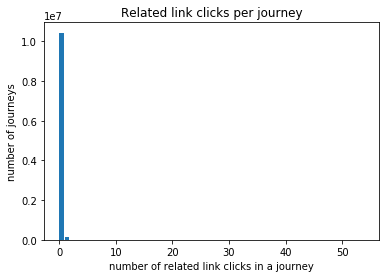

In [49]:
plt.bar(
    group_by_rl_clicks_df['Related Links Clicks per seq'],
    group_by_rl_clicks_df['Occurrences'],
    align='edge')
plt.title('Related link clicks per journey')
plt.ylabel('number of journeys')
plt.xlabel('number of related link clicks in a journey')

Text(0.5, 0, 'number of related link clicks in a journey')

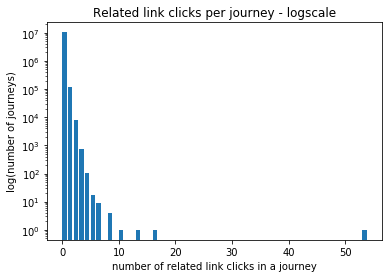

In [50]:
plt.bar(
    group_by_rl_clicks_df['Related Links Clicks per seq'],
    group_by_rl_clicks_df['Occurrences'],
    log=True
    ,align='edge'
)
plt.title('Related link clicks per journey - logscale')
plt.ylabel('log(number of journeys)')
plt.xlabel('number of related link clicks in a journey')

Text(0.5, 0, 'number of related link clicks in a journey')

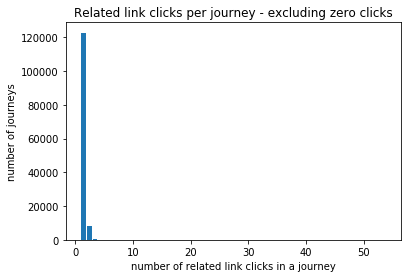

In [51]:
plt.bar(
    group_by_rl_clicks_df_bar_zero['Related Links Clicks per seq'],
    group_by_rl_clicks_df_bar_zero['Occurrences'],
    align='edge')
plt.title('Related link clicks per journey - excluding zero clicks')
plt.ylabel('number of journeys')
plt.xlabel('number of related link clicks in a journey')

Text(0.5, 0, 'number of related link clicks in a journey')

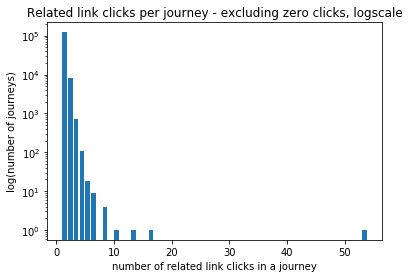

In [52]:
plt.bar(
    group_by_rl_clicks_df_bar_zero['Related Links Clicks per seq'],
    group_by_rl_clicks_df_bar_zero['Occurrences'],
    log=True
    ,align='edge'
)
plt.title('Related link clicks per journey - excluding zero clicks, logscale')
plt.ylabel('log(number of journeys)')
plt.xlabel('number of related link clicks in a journey')

## proportion of journeys with a page sequence including content and related links only

There is no statistically significant difference in the proportion of journeys with a page sequence including content and related links only (including loops) between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of journeys that only contain content pages and related links (i.e. no nav pages)}}{\text{total number of journeys}}
\end{equation*}

### total number of journeys that only contain content pages and related links (i.e. no nav pages)
This will be easier to calculate as total number of journeys that do not contain clicks on navigation elements (home, breadcrumbs, search, explore this topic)

## Other stuff

### total number of pageviews
Not sure we're using this in our metrics

Should these only include ones that HAD related links on them??

If we had col PageSeq_Length we could use that instead

In [40]:
df['Page_List'] = df['Page_List'].apply(ast.literal_eval)

In [41]:
len(df['Page_List'][26010])

1

In [46]:
df['pageviews'] = df['Page_List'].map(len)

In [47]:
df['absolute pageviews count'] = df['pageviews'] * df['Occurrences']

In [48]:
df.head(2)

,Sequence,PageSequence,Occurrences,Page_Seq_Occurrences,DeviceCategories,Dates,Page_Event_List,Page_List,PageSequence_internal,Event_List,...,Event_cat_act_agg,Page_List_NL,Page_Seq_NL,Occurrences_NL,TabletCount,Has_Related,Related Links Clicks per seq,Related Links Clicks row total,pageviews,absolute pageviews count
0,/guidance/rates-and-thresholds-for-employers-2016-to-2017<<PAGE<:<NULL<:<NULL,/guidance/rates-and-thresholds-for-employers-2016-to-2017,75,306.0,"[('desktop', 64), ('mobile', 11), ('tablet', 12)]","[('20181031', 33), ('20181029', 27), ('20181102', 17), ('20181104', 10)]","[('/guidance/rates-and-thresholds-for-employers-2016-to-2017', 'PAGE<:<NULL<:<NULL')]",[/guidance/rates-and-thresholds-for-employers-2016-to-2017],/guidance/rates-and-thresholds-for-employers-2016-to-2017,"[('PAGE_NULL', 'PAGE_NULL')]",...,"[((PAGE_NULL, PAGE_NULL), 1)]",['/guidance/rates-and-thresholds-for-employers-2016-to-2017'],/guidance/rates-and-thresholds-for-employers-2016-to-2017,6198.0,12,False,0,0,1,75
1,/sure-start-maternity-grant/how-to-claim<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<PAGE<:<NULL<:<NULL>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf>>/government/publications/sure-start-maternity-grant-claim-form<<EVENT<:<Download Link Clicked<:<https://assets.pu...,/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,100,385.0,"[('mobile', 50), ('desktop', 50), ('tablet', 4)]","[('20181031', 34), ('20181029', 31), ('20181102', 24), ('20181104', 15)]","[('/sure-start-maternity-grant/how-to-claim', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'PAGE<:<NULL<:<NULL'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<External Link Clicked<:<https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('/government/publications/sure-start-maternity-grant-claim-form', 'EVENT<:<Download Link Clic...","[/sure-start-maternity-grant/how-to-claim, /government/publications/sure-start-maternity-grant-claim-form]",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,"[('PAGE_NULL', 'PAGE_NULL'), ('PAGE_NULL', 'PAGE_NULL'), ('External Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf'), ('Download Link Clicked', 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf')]",...,"[((PAGE_NULL, PAGE_NULL), 2), ((External Link Clicked, https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf), 1), ((Download Link Clicked, https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/749722/sure-start-maternity-grant-sf100.pdf), 1)]","['/sure-start-maternity-grant/how-to-claim', '/government/publications/sure-start-maternity-grant-claim-form']",/sure-start-maternity-grant/how-to-claim>>/government/publications/sure-start-maternity-grant-claim-form,7010.0,4,False,0,0,2,200


In [50]:
# total pageviews
df['absolute pageviews count'].sum()

17207379